Домашнее задание
Задача с конечным набором дискретных действий

Цель:
В процессе выполнения задания вы проведёте первичный анализ поставленной задачи и выберете подходящий алгоритм.
Для успешного выполнения задания вам потребуется:

понимание отличий между средами с дискретными и непрерывным набором действий;
навык оценки задачи и выбора подходящего алгоритма;
навык разработки несложных алгоритмов на Python;
навык реализации нейронных сетей с использованием фреймворка PyTorch;
навык отладки алгоритма и выбора оптимальных гиперпараметров.

Описание/Пошаговая инструкция выполнения домашнего задания:
Пошаговая инструкция:


реализуйте алгоритм DQN с реплей буффером и мягким обновлением целевой сети;
обучите агента в среде Lunar Lander;
представьте исходный код, обученного агента и график средней награды за эпизод и средней наградой за 100 эпизодов по мере обучения агента.
Формат сдачи:


ссылка на проект на Github или другой хостинг кода;
Примерное время выполнения: 3-5 часов.

Критерии оценки:
Работа выполнена студентом (работа является уникальной).
Работа оформлена в соответствии с форматом сдачи.
Средняя награда за эпизод демонстрирует рост по мере обучения агента.
Статус "Принято" ставится при выполнении всех критериев.

Компетенции:
Deep Reinforcement Learning
- понимать DQN и его компоненты, а также модификаций DQN
- понимать основы работы алгоритмов на основе политик
- понимать аппроксимации функций и политик с использованием нейронных сетей в обучении с подкреплением

In [1]:
import gymnasium as gym
import math
import random
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [2]:
plt.style.use('fivethirtyeight')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# DQN with ReplayBuffer and soft uplay target net's weights

In [3]:
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [4]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [5]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

# BATCH_SIZE - количество эпизодов, отобранных из буфера воспроизведения
# GAMMA - коэффициент дисконтирования
# EPS_START - начальное значение эпсилон
# EPS_END - конечное значение эпсилон
# EPS_DECAY - скорость экспоненциального спада эпсилон, чем больше - тем медленнее падение
# TAU - скорость обновления целевой сети
# LR - скорость обучения оптимизатора ``AdamW``.

BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4
FULL_MEMORY_LENGTH = 10000
SEED = 123

# Среда
env = gym.make('LunarLander-v2')

# Получить число действий
n_actions = env.action_space.n
# Получить число степеней свободы состояний
state, info = env.reset(seed=SEED)
n_observations = len(state)

# Инициилизировать сети: целевую и политики
policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)

# Подгрузить в целевую сеть коэффициенты из сети политики
target_net.load_state_dict(policy_net.state_dict())

# Задать оптимайзер
optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)

# Инициализировать Replay Memory buffer
memory = ReplayMemory(FULL_MEMORY_LENGTH)


steps_done = 0

#     массив длительности эпизода - пойдет в отчет о том, сколько продержался агент
episode_durations = []

In [6]:
# еpsilon-жадная стратегия выбора действия
def select_action(state):
    global steps_done  # глобальный шаг для убывания epsilon
#     случайное значение для определения какой шаг будем делать жадный или случайный
    sample = random.random()
    
#     установка порога принятия решения - уровня epsilon
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    
#     увеличиваем счетчик шагов
    steps_done += 1
    
#     если случайный порог больше epsilon-порога
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) вернет наибольшее значение столбца в каждой строке.
            # Второй столбец в результате max - это индекс того места, 
            # где был найден максимальный элемент, 
            # поэтому мы выбираем действие с наибольшим ожидаемым вознаграждением.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        # Иначе выбираем случайное действие
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

In [7]:
def optimize_model(batch_size: int):
    if len(memory) < batch_size:
        return
    
    # Получить из памяти батч
    transitions = memory.sample(batch_size)
    # Преобразовать его в namedtuple
    batch = Transition(*zip(*transitions))

    # Вычислить маску нефинальных состояний и соединить элементы батча
    # (финальным состоянием должно быть то, после которого моделирование закончилось)

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                        batch.next_state)), device=device, dtype=torch.bool)
    
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    
    # Собираем батчи для состояний, действий и наград
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Вычислить Q(s_t, a) - модель вычисляет Q(s_t), 
    # затем мы выбираем столбцы предпринятых действий. 
    # Это те действия, которые были бы предприняты для каждого состояния партии в соответствии с policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Вычислить V(s_{t+1}) для всех следующих состояний.
    # Ожидаемые значения действий для не_финальных_следующих_состояний вычисляются 
    # на основе "старшей" целевой_сети; выбирается их наилучшее вознаграждение с помощью max(1)[0].
    # Это объединяется по маске, так что мы будем иметь либо ожидаемое значение состояния, 
    # либо 0, если состояние было финальным.
    next_state_values = torch.zeros(batch_size, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
    # Вычисляем ожидаемые Q значения
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Объединяем все в общий лосс
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Готовим градиент
    optimizer.zero_grad()
    loss.backward()
    # Обрезаем значения градиента - проблемма исчезающего/взрывающего градиента
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    
    optimizer.step()

In [8]:
if torch.cuda.is_available():
    num_episodes = 1500
else:
    num_episodes = 500
total_reward = []

for i_episode in tqdm(range(num_episodes)):
    episode_reward = 0
    # Для каждого эпизода инициализируем начальное состояние
    state, info = env.reset(seed=SEED)
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    
    # выполняем действия пока не получим флаг done
    # t - считает сколько шагов успели сделать пока шест не упал
    for t in count():
        # выбираем действие [0, 1]
        action = select_action(state)
        # Делаем шаг
        observation, reward, terminated, truncated, _ = env.step(action.item())
        episode_reward += reward

        # Преобразуем в тензор
        reward = torch.tensor([reward], device=device)
        
        # Объединяем done по двум конечным состояниям
        done = terminated or truncated
        
        # присваиваем следующее состояние
        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # отправляем в память
        memory.push(state, action, next_state, reward)

        # переходим на следующее состояние
        state = next_state

        # запускаем обучение сети
        optimize_model(batch_size=128)

        # делаем "мягкое" обновление весов
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)
        
        # Если получили terminated or truncated завершаем эпизод обучения
        if done:
            # добавляем в массив продолжительность эпизода
            episode_durations.append(t + 1)
            total_reward.append(episode_reward)
            break

print('Complete')

100%|██████████| 1500/1500 [45:19<00:00,  1.81s/it] 

Complete


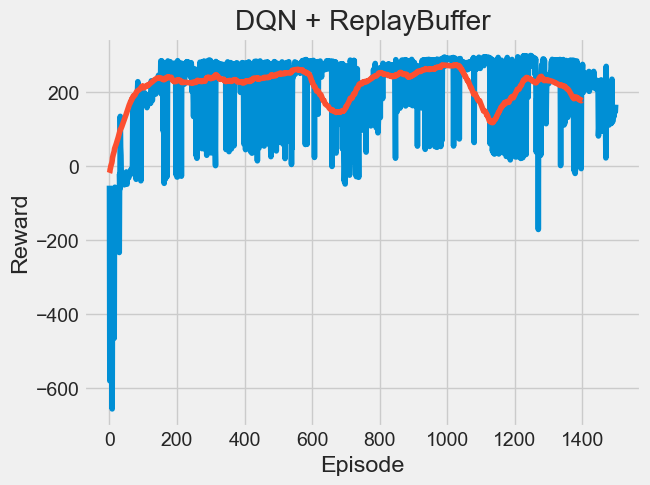

In [12]:
# Вычисление скользящего среднего
window_size = 100
moving_avg = np.convolve(total_reward, np.ones(window_size)/window_size, mode='valid')

plt.plot(total_reward)
plt.plot(moving_avg)
plt.title('DQN + ReplayBuffer')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

# Вывод

Сложно делать выводы, пока просто изучаю алгоритмы и способы их применения. Одного курса точно мало, чтобы научится в этом ориентироваться.